# Introduction to Population Games using Python

### Main initialization code

In [1]:
# Import required modules
import copy
import numpy as np
import matplotlib.pyplot as plt
from utilities import *

np.random.seed(141024) # Fix random seed for reproducibility

# Define main simulation parameters
N = 5000               # Number of agents in the population
n = 3                  # Number of available strategies
T = 50                 # Simulation time
dt = 1e-2              # Step size for the continuous-time discretization
num_iter = int(T/dt)   # Number of iterations for the simulations (number of steps)
R = 1                  # Rate of the exponential distribution for the strategy revision times

# Definition of the fitness vector
A = np.array([[0, -1, 2], 
              [2, 0, -1], 
              [-1, 2, 0]]) # Game: "Good" Rock-Paper-Scissors (EXAMPLE)
def fitness(x):
    return np.dot(A, x).reshape(n, 1)

# Definition of the revision protocol
nu = R/(n-1) # Saturation parameter (to ensure well-posed probabilities)
def revision_protocol(x, p):
    return np.clip(p.reshape(n, 1) - p.reshape(1, n), 0, nu) # Saturated pairwise comparison (EXAMPLE)

# Initialization of the strategic distribution
selected_strategies = np.random.randint(0, n, N)          # Randomly sample the selected strategy for each agent
x = get_strategic_distribution(N, n, selected_strategies) # Get the strategic distribution of the population

### Simulation of the mean dynamics (EDM: Evolutionary Dynamics Model)

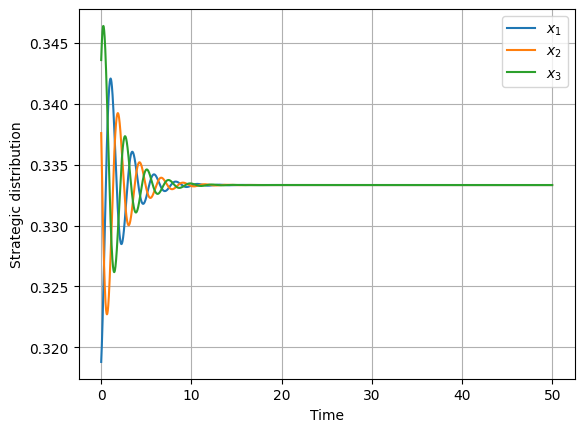

In [2]:
# Mean dynamics
x_log = np.zeros((n, num_iter))
for k in range(num_iter):
    x_log[:, k] = x.reshape(-1)
    p = fitness(x) # Payoff vector (memoryless)
    revs = revision_protocol(x, p)
    dx = np.sum(x.T*revs - x*revs.T, 1).reshape(n, 1) 
    x = x + dt*dx

# Plot results
time = np.arange(num_iter)*dt
plt.figure(1)
for i in range(n):
    plt.plot(time, x_log[i, :], label=r'$x_'+str(i+1)+r'$')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Strategic distribution')
plt.legend();

### Simulation of the finite population (microscopic decision-making process)

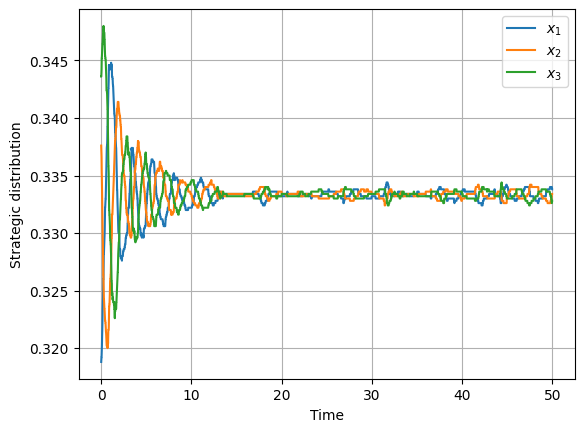

In [3]:
# Generate the revision times for all agents using an exponential distribution with rate R
revision_times = generate_revision_times(N, R, T, dt)

# Run the microscopic decision-making process
x_log = np.zeros((n, num_iter))
for t in range(num_iter):  # Loop over the simulation time steps
    x = get_strategic_distribution(N, n, selected_strategies)  # Compute strategic distribution of the population
    x_log[:, t] = x.reshape(-1)                                # Save strategic distribution (for plotting)
    
    p = fitness(x)                                      # Compute payoff vector
    revision_matrix = revision_protocol(x, p)           # Compute revision protocol (matrix)
    
    revising_agents, _ = np.where(revision_times == t)  # Get the revising agents at time (step) t
    revising_agents = [*set(list(revising_agents))]     # Eliminate repetitions

    selected_strategies_t = copy.deepcopy(selected_strategies) # Make copy of selected strategies at time (step) t
    for agent in revising_agents:                              # Loop over the revising agents
        probabilities = []                                     # Initialize probabilities placeholder
        i = selected_strategies_t[agent]                       # Current selected strategy of current agent
        for j in range(n):
            probability_ij = revision_matrix[j, i]/R           # Compute switching probabilities
            probabilities.append(probability_ij)
        probabilities[i] = 1 - sum(probabilities)
        selected_strategies[agent] = np.random.choice(np.arange(n), p=probabilities) # Update selected strategy of current agent

# Plot results
time = np.arange(num_iter)*dt
plt.figure(1)
for i in range(n):
    plt.plot(time, x_log[i, :], label=r'$x_'+str(i+1)+r'$')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Strategic distribution')
plt.legend();            

## Exercise

<p style="text-align: justify;">
Modify the fitness vector and the revision protocol (in the "Main initialization code" cell) to replicate the demand response scenario (for a single population and a continuously triggered payoff provider) of the paper: 

J. Martinez-Piazuelo, W. Ananduta, C. Ocampo-Martinez, S. Grammatico and N. Quijano, "Population Games With Replicator Dynamics Under Event-Triggered Payoff Provider and a Demand Response Application," in IEEE Control Systems Letters, vol. 7, pp. 3417-3422, 2023, doi: 10.1109/LCSYS.2023.3285532.

The fitness vector for such a setup is:

$$\mathbf{f}(\mathbf{x}) = \alpha(\mathbf{x}^*-\mathbf{x}),$$

where $\alpha\in\mathbb{R}_{>0}$ is a positive gain parameter and $\mathbf{x}^*$ is the desired Nash equilibrium to be achieved.

On the other hand, the revision protocol for the replicator dynamics is given by:

$$ \rho_{ij} := x_i\max\left(p_j-p_i,\, 0\right), \qquad \forall i,j\in\mathcal{S}.$$

Besides, it is suggested to include a saturation of the form:

$$ \rho_{ij} := x_i\max\left(\min(p_j-p_i, \,\nu),\, 0\right), \qquad \forall i,j\in\mathcal{S},$$

with $\nu=R/(n-1)$ to keep the switching probabilities well-posed under the current implementation of the replicator dynamics.
</p>





